In [1]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage as ndi
import cv2

# Modélisation du problème et premières réfléxions

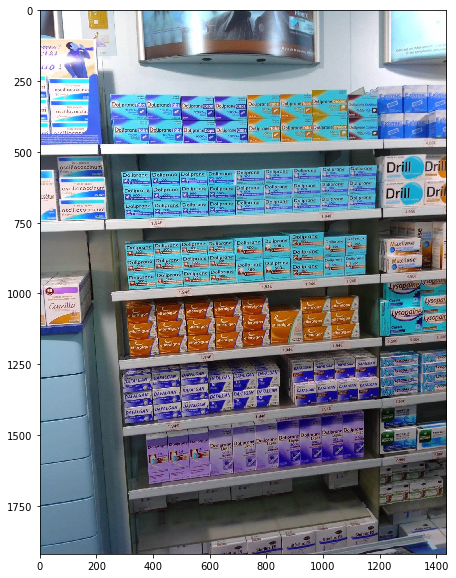

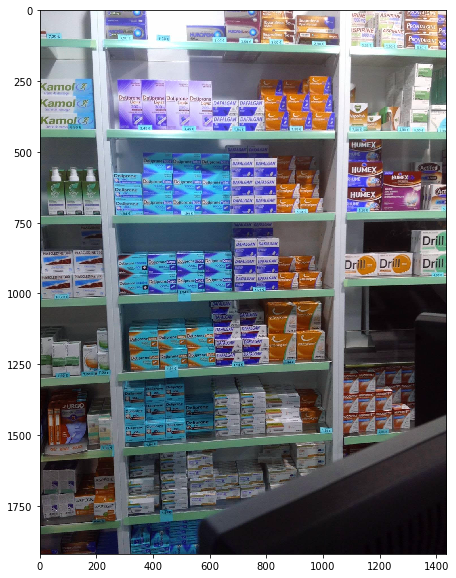

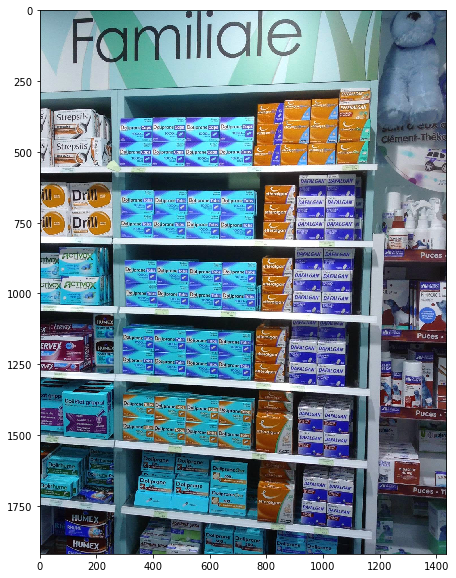

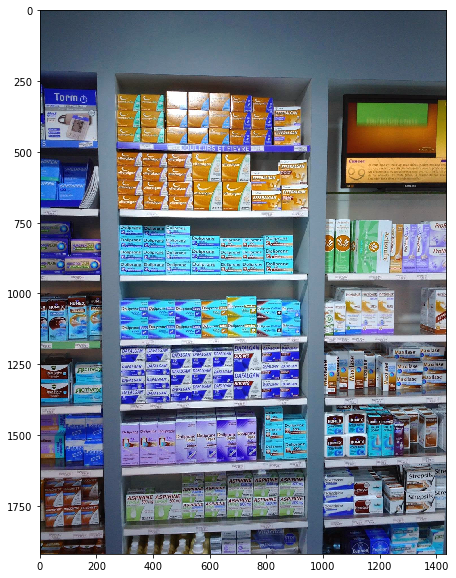

In [78]:
img1 = cv2.imread('1.jpg')
img2 = cv2.imread('2.jpg')
img3 = cv2.imread('3.jpg')
img4 = cv2.imread('4.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(img1)
plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.figure(figsize=(10, 10))
plt.imshow(img3)
plt.figure(figsize=(10, 10))
plt.imshow(img4)

On dispose d'image d'étagères de produits de pharmacie, comme sur l'image ci-dessus. L'objectif est de pouvoir détecter la position des étagères. On fera l'hypothèse qu'elles sont toutes horizontales.

# Première approche : Détecteur de Canny

Comme nous en avions parlé, je reprends juste ce travail, pour montrer rapidement en quoi il n'est pas satisfaisant pour notre problème.

In [6]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

Trouver les paramètres du filtre est une vraie plaie, j'ai opté pour une procédure automatique.

In [7]:
def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

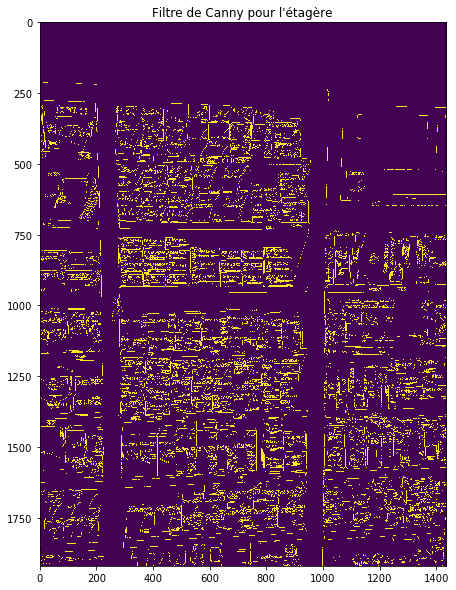

In [82]:
img1_bw = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(img1_bw, (3, 3), 0)
edges = auto_canny(blurred, sigma=10)
plt.figure(figsize=(10, 10))
plt.imshow(edges)
plt.title("Filtre de Canny pour l'étagère")

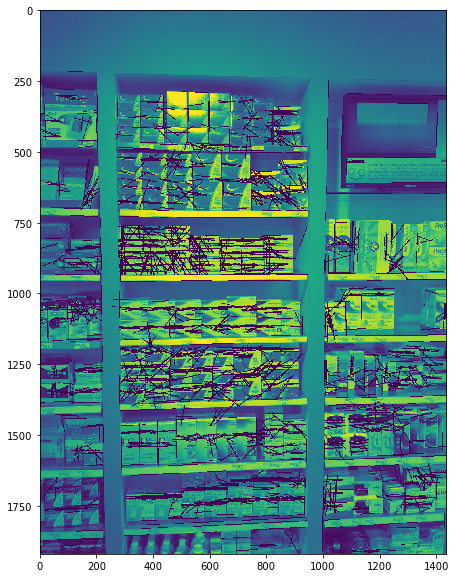

In [93]:
img1_bw = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(img1_bw, (3, 3), 0)
edges = auto_canny(blurred, sigma=10)

lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=10, minLineLength=50, maxLineGap=10)


for line in lines:
    x1, y1, x2, y2 = line[0]
    
    cv2.line(img1_bw,(x1,y1),(x2,y2),(0,255,0),2)
    
cv2.imwrite('houghlines0.jpg',img1_bw)
plt.figure(figsize=(10, 10))
plt.imshow(img1_bw)


Un problème est net avec cette méthode. Même si elle permet sûrement à terme d'obtenir les frontières des étagères, elle détecte aussi et surtout les frontières des médicaments, ce que l'on ne souhaite pas.
Il faut trouver une solution pour que ceux-ci disparaissent des lignes détectées.

# Deuxième approche plus fine

/home/pierre/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in int_scalars
  del sys.path[0]


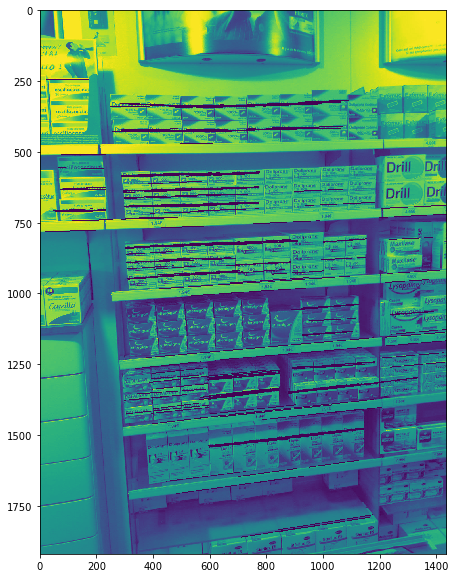

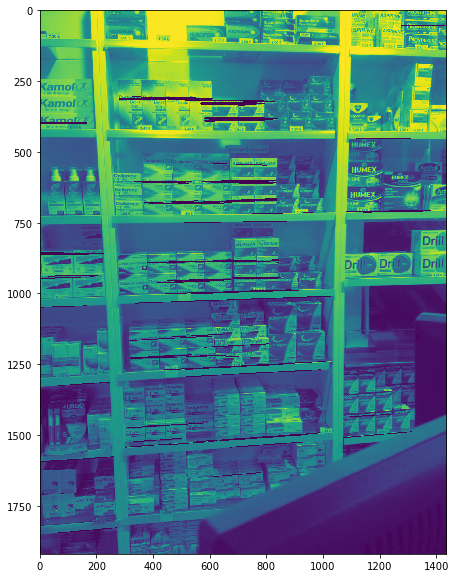

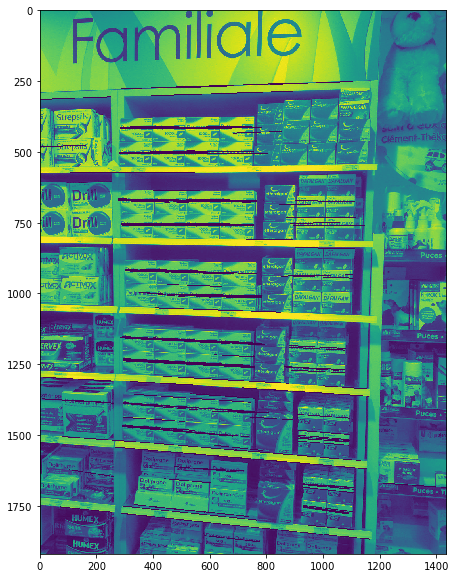

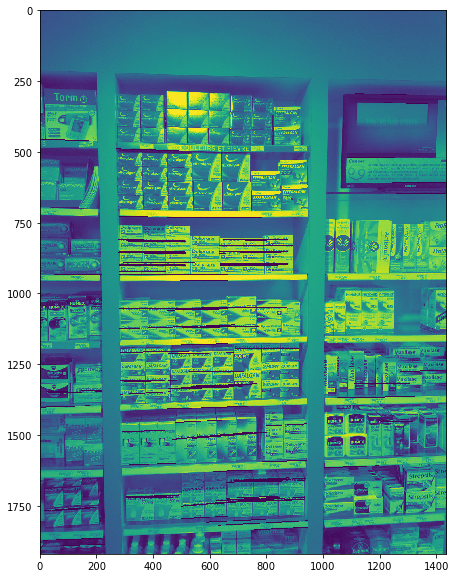

In [136]:
def methode2(img, path='houghlinesm1.jpg'):
    res = []
    img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(img_bw, (3, 3), 0)
    edges = auto_canny(blurred, sigma=10)

    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=80, minLineLength=150, maxLineGap=10)

    h,w = np.shape(img1_bw)
    treshold = 0.3 * h / w
    for line in lines:
        x1, y1, x2, y2 = line[0]    
        m = (y2 - y1) / (x2 - x1) # coefficient directeur de la droite associée
        if np.abs(m) <= treshold:
            cv2.line(img_bw,(x1,y1),(x2,y2),(0,255,0),2)
            res.append([x1, y1, x2, y2])
    if path is not None:   
        cv2.imwrite(path, img_bw)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_bw)
    return res
    
    
    
a = methode2(img1, path="houghlinesm1_1.jpg")
a = methode2(img2, path="houghlinesm1_2.jpg")
a = methode2(img3, path="houghlinesm1_3.jpg")
a = methode2(img4, path="houghlinesm1_4.jpg")

On a isolé les lignes verticales. L'objectif est maintenant d'isoler les lignes qui nous intéressent : celles des étagères. On apprend quelque chose de très intéressant vis-à-vis de notre objectif : **par moyennage, on peut connaître la pente des étagères**!

Un critère sur les densités selon uniquement $y$ est une mauvaise idée, dans la mesure où on voit bien que pour une étagère, on peut trouver des lignes ne correspondant pas à des étagères à une valeur similaire de $y$.